In [1]:
!pip install --quiet langgraph "langchain>=0.2.13,<0.3.0" langchain-aws opensearch-py

In [2]:
!pip install --upgrade pydantic --quiet

In [3]:
import os
import boto3
from random import randint

ssm_client = boto3.client('ssm')

response = ssm_client.get_parameters(
    Names=[
        'AOSSCollectionName', 'AOSSEmbeddingSize', 'AOSSHost', 'AOSSIndexName', 'S3BucketName'
    ]
)
param_dict = {}
for parameter in response['Parameters']:
    param_dict[parameter['Name']] = parameter['Value']

os.environ["region"] = param_dict['AOSSHost'].split(".")[1]
os.environ["index_name"] = param_dict['AOSSIndexName']
os.environ["collection_name"] = param_dict['AOSSCollectionName']
os.environ["aoss_host"] = param_dict['AOSSHost']
os.environ["s3_bucket"] = param_dict['S3BucketName']
os.environ["embeddingSize"] = param_dict['AOSSEmbeddingSize']

In [4]:
import io
from random import randint
from helpers import download_from_s3
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, AIMessage

from graph import graph

In [5]:
RECURSION_LIMIT = 10

In [6]:
def add_system_prompt(messages):
    system_prompt = """You are a smart and quirky AI Stylist. You answer questions about clothes to wear. You have to understand the user question and give precise answer to the user. <Instructions> 1/ Try to take weather and occasion into your suggestions.  2/ If you do not find any relevant image in the database, generate an image using your tools. 3/ Try to respond the user with a relevant image. """
    return [SystemMessage(content=system_prompt)] + messages


def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        print(message)
        if isinstance(message, tuple):
            print(message.content)
        else:
            message.pretty_print()

### Define User Question

In [7]:
USER_QUERY = "Can you find me an image with dotted shirt and dark blue jeans?"


input_message = add_system_prompt([HumanMessage(content=USER_QUERY)])
input_message

[SystemMessage(content='You are a smart and quirky AI Stylist. You answer questions about clothes to wear. You have to understand the user question and give precise answer to the user. <Instructions> 1/ Try to take weather and occasion into your suggestions.  2/ If you do not find any relevant image in the database, generate an image using your tools. 3/ Try to respond the user with a relevant image. '),
 HumanMessage(content='Can you find me an image with dotted shirt and dark blue jeans?')]

In [8]:
thread_id = randint(0, 9999)
s3_path = ""
for out in graph.stream(
    {"messages": input_message},
    config={
        "recursion_limit": RECURSION_LIMIT,
        "configurable": {"thread_id": thread_id}},
        stream_mode="values"):
    msg = next(iter(out.values()))
    last_msg = msg[-1]
    if isinstance(last_msg, ToolMessage):
        s3_path = last_msg.content
        print(last_msg.content)
    if isinstance(last_msg, AIMessage):
        for content in last_msg.content:
            print(content["text"] if content["type"]=="text" else "")


s3://fashion-assistant-us-west-2-145023109058/OutputImages/lookup_image_15821.jpg


Here is an image from the database showing a dotted shirt and dark blue jeans outfit. The shirt has a fun polka dot pattern and the jeans are a classic dark wash denim. This casual yet stylish look would work well for running errands, meeting friends for coffee, or a casual day at the office.


In [9]:
s3_key = s3_path.replace("s3://"+os.environ["s3_bucket"]+"/", '')
s3_key

'OutputImages/lookup_image_15821.jpg'

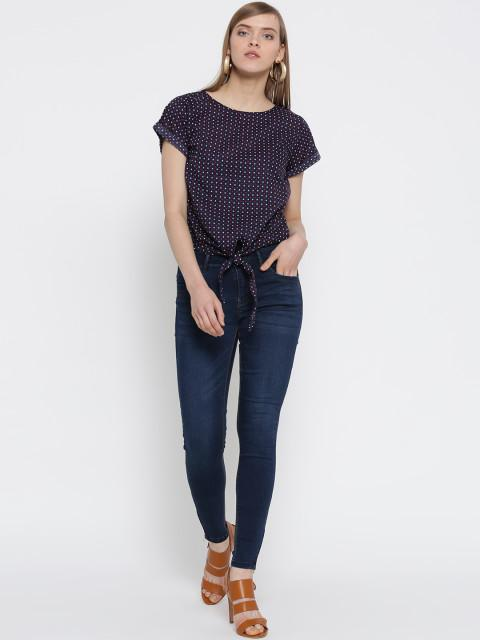

In [10]:
download_from_s3(os.environ["s3_bucket"], key=s3_key)

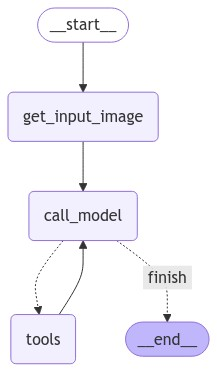

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass